In [1]:
%%html
<style>body{--vscode-font-family: "D2Coding"}</style>

In [2]:
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
from scipy.special import jv, kv, jvp, kvp, jn_zeros, jnp_zeros
from scipy.optimize import fsolve, minimize

# Solving Characteristic equations

Circular core step-index fiber의 general mode의 고유값 방정식을 다음과 같이 Bessel fucntion의 미분형태를 포함한 채로 정의할 수있다.  
수치계산을 할 때 베셀함수의 미분형을 그대로 사용할 수 있으므로 recurrence relation of Bessel function을 수고스럽게 적용하여 바꿀 필요는 없다.

## Hybrid mode equation

$$
\left[\frac{w J_q'(u)}{J_q(u)} + \frac{u K_q'(w)}{K_q(w)} \right]
\left[\left(\frac{n_1}{n_2}\right)^2 \frac{w J_q'(u)}{J_q(u)} + \frac{u K_q'(w)}{K_q(w)} \right]  
=
q^2
V^2
\left[\left(\frac{n_1}{n_2}\right)^2 \frac{1}{u^2}+\frac{1}{w^2}\right]
$$

$TE, TM$ 모드는 다음과 같이 위의 eigenvalue equation of hybrid mode에서 q=0을 만족하는 다음 두 경우로 정의할 수 있다.
## TE mode equation

$$
\frac{w J_q'(u)}{J_q(u)} + \frac{u K_q'(w)}{K_q(w)} = 0
$$

## TM mode equation

$$
\left(\frac{n_1}{n_2}\right)^2 \frac{w J_q'(u)}{J_q(u)} + \frac{u K_q'(w)}{K_q(w)} = 0
$$

In [3]:
def gen_eigen_eq(v:float, ncore: float, nclad: float, q: int, **kwargs) -> callable:

  def wjf(u):
    w = np.sqrt(v*v - u*u)
    return w * jvp(q, u) / jv(q,u)

  def ukf(u):
    w = np.sqrt(v*v - u*u)
    return u * kvp(q, w)/ kv(q,w)

  def qvf(u):
    w = np.sqrt(v*v - u*u)
    n_sq= (ncore/nclad)**2
    return q*q*v*v*(n_sq/(u*u)+1/(w*w))
  
  def te(u):
    return wjf(u) + ukf(u)
  
  def tm(u):
    n_sq= (ncore/nclad)**2
    return n_sq * wjf(u) + ukf(u)
  
  def hybrid(u):
    return te(u) * tm(u) - qvf(u)

  if kwargs.get("mode")=="te":
      q = 0
      return te
  
  if kwargs.get("mode")=="tm":
      q = 0
      return tm
  
  if kwargs.get("mode")=="hybrid":
    return hybrid

In [4]:
def num_of_zeros_jn(v: float, q: int) -> int:
  """Returns maximum number of zero points of Bessel where its variable less than v-value"""
  count: int = 1
  while jn_zeros(q, count)[-1] < v:
    count += 1
    if count > 100:
      raise ValueError("Too many points of Bessel zeros")
  num = count - 1 
  return num

In [5]:
def get_diverging_points(v: float, q: int) -> list:
  """Returns list of values where Bessel jn(q, u) goes to zero"""
  num: int = num_of_zeros_jn(v, q)
  if num ==0:
    return None
  else:
    diverging_points = jn_zeros(q, num)
    return diverging_points

In [6]:
def get_init_points_to_solve_TEM(v):
  diverging_points = get_diverging_points(v, 0)
  if diverging_points is not None:
    offset = (v - diverging_points[-1])/2 # critical to avoide RuntimeWarning
    init_points = diverging_points + offset
    return init_points
  else:
    return None

In [7]:
def get_roots_for_TEM(eigen_eq: callable, init_points: list[float], v) -> list[float]:
  init_points = get_init_points_to_solve_TEM(v)

  if init_points is not None:
    with warnings.catch_warnings():
      warnings.simplefilter("error", RuntimeWarning)
      near_v = (v + get_diverging_points(v, 0)[-1])/2

      try:
        roots = fsolve(eigen_eq, init_points)
      except RuntimeWarning as e:
        print(f"\nRuntimeWarning: {e}")
        if len(init_points) == 1:
          roots[-1] = near_v
        else:
          roots = fsolve(eigen_eq, init_points[:-1])
          roots = np.append(roots, near_v)
        print("The last solution is replaced by the near value V.\n")
      finally:
        return roots
  else:
    return None

In [8]:
def plot_eigen_eq(eigen_eq, v, plot_limit=None):

  fig, ax = plt.subplots(figsize=(10, 4))

  if plot_limit is None:
    plot_limit = 3*v

  ax.set_ylim(-plot_limit, plot_limit)
  ax.hlines(y=0, xmin=0, xmax=v, colors='k', linewidth=0.5) # plot x axis.
  u = np.linspace(0.0001, v-0.0001, int(v*2000))

  eigen_plot = eigen_eq(u)
  eigen_plot = np.where(abs(eigen_plot) >= 20000, None, eigen_plot)
  ax.plot(u, eigen_plot)


  ax.set_xlabel("$u$")
  ax.xaxis.set_minor_locator(AutoMinorLocator(10))


  return (fig, ax)

In [91]:
def plot_diverging_points(ax, v, q, plot_limit=None):
  # plot diverging assymtotic lines
  if plot_limit is None:
    plot_limit = 5*v
  diverging_pionts = get_diverging_points(v, q)
  if diverging_pionts is not None:
    print(f"diverging points = {diverging_pionts}, {len(diverging_pionts)} points")
  ax.vlines(x=diverging_pionts, ymin=-plot_limit, ymax=plot_limit, linestyles='dashed', colors='k', alpha=0.5, linewidth=0.9)

In [92]:
def plot_roots(ax, roots, plot_limit=None):
  if plot_limit is None:
    plot_limit = 10*roots[-1]
  if roots is not None:
    print(f"roots = {roots}")
  ax.vlines(x=roots, ymin=-plot_limit, ymax=0, linestyles='dashed', colors='r', linewidth=1.0, label="Roots")

## TE mode test

V = 11.79163
diverging points = [ 2.40482556  5.52007811  8.65372791 11.79153444], 4 points
roots = [ 3.52809655  6.43853511  9.27018126 11.79162396]


Text(0.5, 1.0, '$TE_{0m}$ modes @V=11.792')

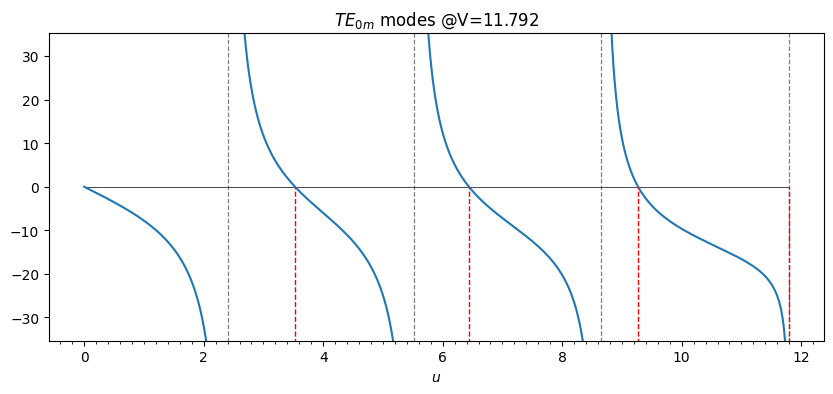

In [93]:
v = jn_zeros(0, 4)[-1] + 0.0001
print(f"V = {v:.5f}")
na = 0.3
nclad = 1.444
ncore = np.sqrt(na*na + nclad*nclad)

eigen_te = gen_eigen_eq(v, ncore, nclad, q=0, mode='te')
fig, ax = plot_eigen_eq(eigen_te, v)
plot_diverging_points(ax, v, 0)
roots = get_roots_for_TEM(eigen_te, get_init_points_to_solve_TEM(v), v)
plot_roots(ax, roots)
ax.set_title(r"$TE_{0m}$ modes"+f" @V={v:.3f}")

## TM mode test

V = 11.79163
diverging points = [ 2.40482556  5.52007811  8.65372791 11.79153444], 4 points
roots = [ 3.53857651  6.45516587  9.28719205 11.79162439]


Text(0.5, 1.0, '$TM_{0m}$ modes @V=11.792')

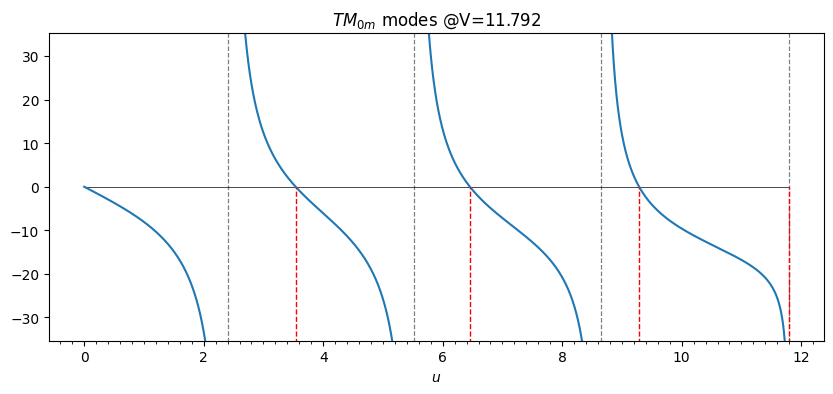

In [94]:
v = jn_zeros(0, 4)[-1] + 0.0001
print(f"V = {v:.5f}")
na = 0.3
nclad = 1.444
ncore = np.sqrt(na*na + nclad*nclad)

eigen_tm = gen_eigen_eq(v, ncore, nclad, q=0, mode='tm')
fig, ax = plot_eigen_eq(eigen_tm, v)
plot_diverging_points(ax, v, 0)
roots = get_roots_for_TEM(eigen_tm, get_init_points_to_solve_TEM(v), v)
plot_roots(ax, roots)
ax.set_title(r"$TM_{0m}$ modes"+f" @V={v:.3f}")

## Hybrid mode test

In [127]:
def get_local_minimum(eigen_eq: callable, v: float, q: int):
  step_size = 10
  diverging_points = get_diverging_points(v, q)

  if diverging_points is None:
    return None
  else:
    slots = np.append(diverging_points, v-1E-6)
    initial_guesses = []
    local_minima = np.array([])

    for i in range(len(slots)-1):
      initial_guesses.extend(np.linspace(slots[i], slots[i+1], step_size))
    
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", RuntimeWarning)
      for guess in initial_guesses:
        result = minimize(eigen_eq, x0=guess)
        if result.success and not any(np.isclose(result.x, [x for x in local_minima], atol=1/step_size)):
          local_minima = np.append(result.x[0], local_minima)
    if np.size(local_minima) == 0:
      return None
    else: 
      return list(np.sort(local_minima))

In [128]:
def plot_local_minimum(ax, local_minimums, v, plot_limit=None):
  if plot_limit is None:
    plot_limit = 5*v
  if local_minimums is not None:
    print(f"local minimums = {local_minimums}, {len(local_minimums)} minimums")
    ax.vlines(x=local_minimums, ymin=-plot_limit, ymax=0, linestyles='dashed', colors='g', alpha=0.5, linewidth=0.9)

In [129]:
def get_init_points_to_solve_hybrid(eigen_eq: callable, v: float, q: int) -> list[float]:
  diverging_points = get_diverging_points(v, q)
  init_points = []
  if diverging_points is None:
    if eigen_eq(v-0.0000001) < 0:
      return None
    else:
      init_points.append(v*0.7)
      return init_points
  else:
    init_points.append(diverging_points[0]*0.7) # for solution of Hq1 mode (first solution)
    local_minimums = get_local_minimum(eigen_eq, v, q)
    local_minimums_except_last = local_minimums[:-1]
    if local_minimums is not None:
      offset = 0.1 # Don't change this value
      offset_local_minimums_except_last = [val for x in local_minimums_except_last for val in (x - offset, x + offset)]
      init_points += offset_local_minimums_except_last
      print(f"init_points to solve: {init_points}")
      return init_points
    else:
      return init_points

In [135]:
def get_roots_for_hybrid(eigen_eq: callable, v, q) -> list:
  diverging_points = get_diverging_points(v, q)
  local_minimums = get_local_minimum(eigen_eq, v, q)
  step_size = 5

  slots = diverging_points + local_minimums
  slots.sort()

  # Initialize an empty list to store the initial guesses
  initial_guesses_to_solve = []

  # Iterate over the adjacent pairs of elements in the combined slots
  for i in range(len(slots)-1):
    guesses = np.linspace(slots[i], slots[i+1], step_size)
    initial_guesses_to_solve.extend(guesses)

  # Convert the list to a set to discard duplicate values, then back to a list
  initial_guesses = list(set(initial_guesses))
  initial_guesses.sort()

  unique_solutions = set() # Set to store unique valid solutions

  # Iterate over the range of initial guesses
  for guess in initial_guesses_to_solve:
      with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          try:
              # Use fsolve to find the root
              solution = fsolve(eigen_eq, guess)
              # Check if the solution is valid (e.g., within a certain tolerance)
              if np.isclose(eigen_eq(solution), 0):
                  # Add the solution to the set (converting to a tuple to make it hashable)
                  unique_solutions.add(tuple(solution))
          except RuntimeError:
              # Discard solutions that raise RuntimeError
              continue
  # Convert the set back to a list for easier handling
  valid_solutions = list(unique_solutions)
  return valid_solutions

V = 11.06471
number of diverging points: 1
eigen function value at V: 113512799.44226
diverging points = [7.58834243], 1 points
local minimums = [8.245353619781836], 1 minimums


UnboundLocalError: cannot access local variable 'initial_guesses' where it is not associated with a value

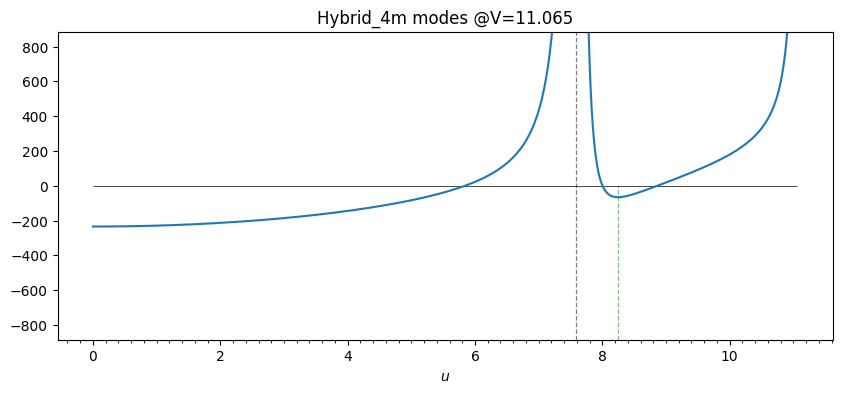

In [136]:
q = 4
# v = 8.43275
v = jn_zeros(q, 2)[-1]
print(f"V = {v:.5f}")
print(f"number of diverging points: {num_of_zeros_jn(v,q)}")
na = 0.3
nclad = 1.444
ncore = np.sqrt(na*na + nclad*nclad)

eigen_hybrid = gen_eigen_eq(v, ncore, nclad, q, mode='hybrid')
print(f"eigen function value at V: {eigen_hybrid(v-1E-6):.5f}")
local_minimums = get_local_minimum(eigen_hybrid, v, q)

plot_limit = 20*q*v
fig, ax = plot_eigen_eq(eigen_hybrid, v, plot_limit)
ax.set_title(f"Hybrid_{q}m modes @V={v:.3f}")
plot_diverging_points(ax, v, q, plot_limit)
plot_local_minimum(ax, local_minimums, v, plot_limit)
# ax.set_xlim(v-1E-1, v)
# ax.set_ylim(-10000, 10000)

# roots analysis
roots = get_roots_for_hybrid(eigen_hybrid, v, q)

확인된 사항들
- local minimum 값에서 $\pm$ offset 0.1 로 초기값을 설정하면 문제없이 양쪽의 해가 찾아진다.

위 테스트 결과 해결할 사항들

- eigen function의 local minimum들을 빠짐없이 찾는 알고리즘
- V 값이 발산 포인트보다 아주 조금 클 때의 함수 양태 정리
- 마지막 솔루션 찾는 알고리즘

In [18]:
def b(v, u: float) -> float:
  """normalized phase constant"""
  return 1-u*u/(v*v)

In [19]:
def neff(b: float, ncore: float, nclad: float) -> float:
  return np.sqrt(b * (ncore*ncore - nclad*nclad)+nclad*nclad)